In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [4]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda,UpSampling2D


# Understaning Upsample and Conv2DTranspose

In [5]:
inp = np.random.randint(0,255,(16,16))

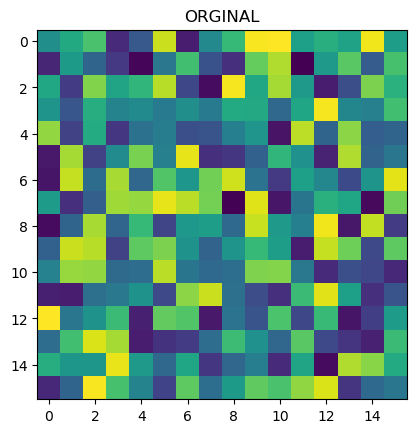

In [6]:
plt.title("ORGINAL")
plt.imshow(inp)

In [7]:
mp =  MaxPooling2D((2,2))
up = UpSampling2D((2,2))

In [8]:
inp1 = inp.reshape([1,16,16,1])
#inp1 = tf.convert_to_tensor(inp1)


In [9]:
inp1.shape

(1, 16, 16, 1)

In [10]:
out =  mp(inp1)

Text(0.5, 1.0, 'Max Polled Data')

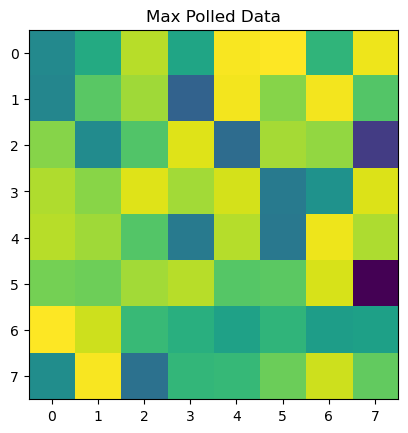

In [11]:
plt.imshow(out.numpy()[0].reshape([8,8]))
plt.title("Max Polled Data")

In [12]:
out.shape

TensorShape([1, 8, 8, 1])

UpSamplled

In [13]:
outup =  up(out)

In [14]:
outup.shape

TensorShape([1, 16, 16, 1])

Text(0.5, 1.0, 'UpSampling2D')

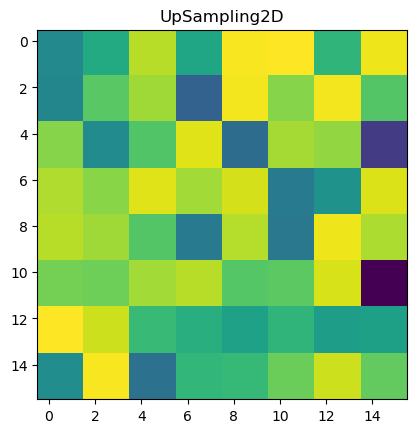

In [15]:
plt.imshow(outup.numpy()[0].reshape([16,16]))
plt.title("UpSampling2D")

In [16]:
cup =  Conv2DTranspose(1,(1,1),(2,2),kernel_initializer='ones')

In [17]:
from keras.models import Sequential
inpo = out.numpy().reshape([1,8,8,1]).astype('float32') # required float32
outcup = cup(inpo)

Text(0.5, 1.0, 'CONV2D Transpose')

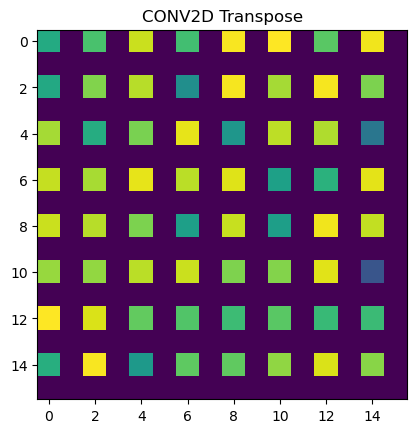

In [18]:
plt.imshow(outcup.numpy()[0].reshape([16,16]))
plt.title("CONV2D Transpose")

#  Data Understanding

Resizing training images and masks


C:\Users\admin\AppData\Local\Temp\ipykernel_18944\1448879970.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)


  0%|          | 0/670 [00:00<?, ?it/s]

C:\Users\admin\AppData\Local\Temp\ipykernel_18944\1448879970.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


Resizing test images


  0%|          | 0/65 [00:00<?, ?it/s]

C:\Users\admin\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done!


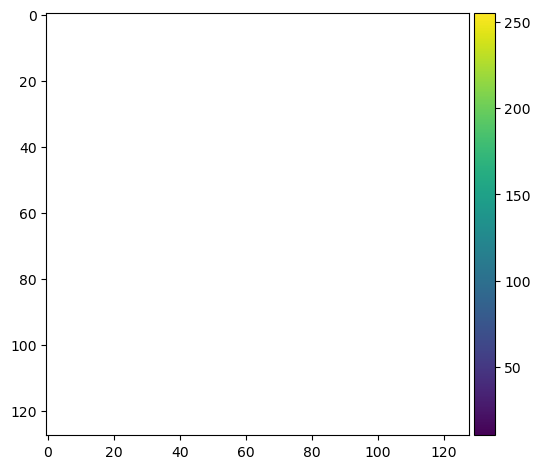

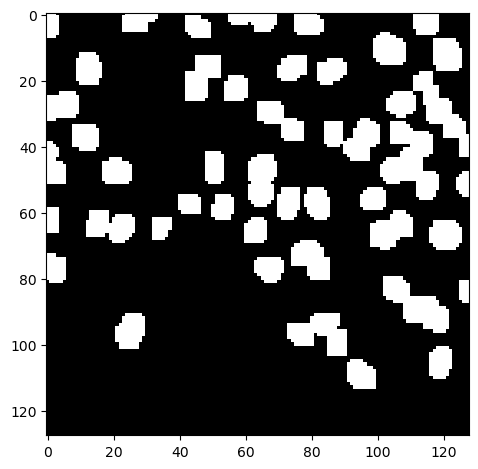

In [19]:
from matplotlib.pyplot import imread
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

TRAIN_PATH = "data/unet/stage1_train/"
TEST_PATH = "data/unet/stage1_test/"
train_ids =  next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
Y_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)

train_ids =  next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    #print(path)
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    #print(img.shape)
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')
import random
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

# Constructor

In [20]:


class Constractor(keras.layers.Layer):
    def __init__(self,nodes):
        super(Constractor,self).__init__()
        self.drop_out_ratio =  0.2
        self.mp_stride =  (2,2)
        self.drop = Dropout(self.drop_out_ratio)
        self.mp = MaxPooling2D(self.mp_stride)
        self.nodes = nodes
        self.conv =  Conv2D(self.nodes,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')
        self.conv2 =  Conv2D(self.nodes,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')
        
    #def get_config(self):return {"units": self.nodes,"DropOut":self.drop_out_ratio,"Pooling_Stride":self.mp_stride}
        
    def call(self,inputs):
        cs = self.conv(inputs)
        cs = self.drop(cs)
        cs = self.conv2(cs)
        ps = self.mp(cs)
        return ps,cs
    
    
    


# Testing Constructor

In [21]:


def test_cons(inp):
    
    _,cs_test = Constractor(16)(inp)
    _,cs_test = Constractor(32)(cs_test)
    _,cs_test = Constractor(64)(cs_test)
    _,cs_test = Constractor(128)(cs_test)
    #_,cs_test = Constractor(256)(cs_test)
    
    return cs_test

In [22]:
test_cons(np.array([X_train[0]])).shape

TensorShape([1, 128, 128, 128])

# Decoding

In [23]:
class Destructor(keras.layers.Layer):
    def __init__(self,nodes,linkage,axis=None):
        super(Destructor,self).__init__()
        self.drop_out_ratio =  0.2
        self.mp_stride =  (2,2)
        self.drop = Dropout(self.drop_out_ratio)
        self.mp = MaxPooling2D(self.mp_stride)
        self.nodes = nodes
        self.linkage = linkage
        self.axis = axis
        self.conv =  Conv2D(self.nodes,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')
        self.conv2 =  Conv2D(self.nodes,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')
        self.convT = Conv2DTranspose(self.nodes,(2,2),(2,2),padding='same')
        
    def get_config(self):
        return {"units": self.nodes,"DropOut":self.drop_out_ratio,"Pooling_Stride":self.mp_stride}

    def call(self,inputs):
        cs = self.convT(inputs)
        if self.axis is None:
            c2 =  concatenate([cs,self.linkage])
        else:
            c2 = concatenate([cs,self.linkage],axis=self.axis)
        c2 = self.conv(cs)
        cs = self.drop(cs)
        cs = self.conv2(cs)
        return cs

#  Unet Model

In [24]:
class UNET(keras.Model):
    def __init__(self,**kwargs):
        super().__init__(self,**kwargs)
        self.c16 = Constractor(16)
        self.c32 = Constractor(32)
        self.c64 = Constractor(64)
        self.c128 = Constractor(128)
        self.c256 = Constractor(256)
        
        
        
    def call(self,inputs,training=False):
    
        p1,c1 = self.c16(inputs)
        p2,c2 = self.c32(p1)
        p3,c3 = self.c64(p2)
        p4,c4 = self.c128(p3)
        p5,c5 = self.c256(p4)
        
        
        self.d16 = Destructor(16,c1,axis=1)
        self.d32 = Destructor(32,c2)
        self.d64 = Destructor(64,c3)
        self.d128 = Destructor(128,c4)

        ct6 = self.d128(c5)
        ct7 = self.d64(ct6)
        ct8 = self.d32(ct7)
        ct9 = self.d16(ct8)
        
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(ct9) 
        
        return outputs
      
        
    def model(self):
        x = Input((128,128,3))
        return Model(inputs=[x],outputs=[self.call(x)])
        
        

In [25]:



unet = UNET().model()

unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#his = unet.fit(X_train,Y_train,validation_split=0.2,verbose=1,epochs=30)

In [26]:
from keras.utils import plot_model

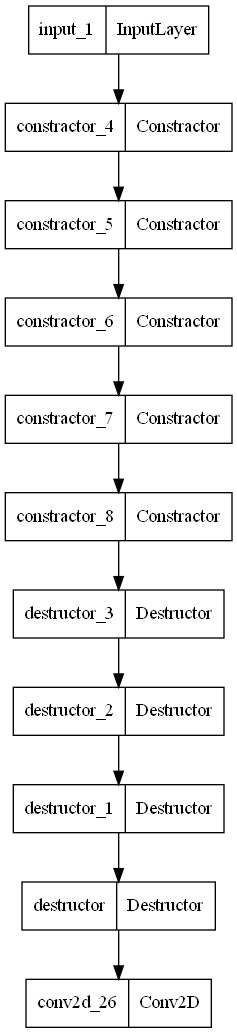

In [27]:
plot_model(unet)

In [28]:

%reload_ext tensorboard

check_point = tf.keras.callbacks.ModelCheckpoint("model_v1.h5",verbose=1,save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]


his = unet.fit(X_train,Y_train,batch_size=64,epochs=30,validation_split=0.2,callbacks=callbacks,verbose=1)

Layer Constractor has arguments ['nodes']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/30
9/9 [==============================] - 41s 4s/step - loss: 3.1211 - accuracy: 0.6824 - val_loss: 0.6908 - val_accuracy: 0.7370
Epoch 2/30
9/9 [==============================] - 40s 4s/step - loss: 0.6679 - accuracy: 0.6979 - val_loss: 0.6774 - val_accuracy: 0.7614
Epoch 3/30
9/9 [==============================] - 40s 4s/step - loss: 0.6477 - accuracy: 0.7199 - val_loss: 0.6505 - val_accuracy: 0.7604
Epoch 4/30
9/9 [==============================] - 41s 5s/step - loss: 0.6033 - accuracy: 0.7276 - val_loss: 0.5657 - val_accuracy: 0.7589
E

In [29]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 17196), started 0:28:56 ago. (Use '!kill 17196' to kill it.)

In [43]:
acc =  unet.predict(X_test)

3/3 [==============================] - 1s 212ms/step


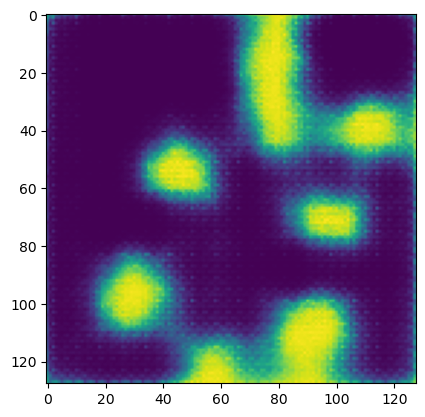

In [49]:
plt.imshow(acc[9])#.shape

1/1 [==============================] - 0s 42ms/step


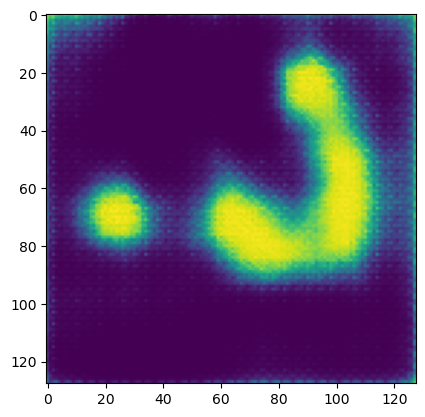

In [40]:
plt.imshow(unet.predict(np.array([X_test[0]]))[0])

# BASIC UNDERSTANDING

In [315]:
def build_model(input_shape):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) 
    inp  = keras.layers.Lambda(lambda x: x/255)(inputs)


    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inp)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

model = build_model(input_shape=inputs)

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_110 (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_24 (Lambda)             (None, 128, 128, 3)  0           ['input_110[0][0]']              
                                                                                                  
 conv2d_516 (Conv2D)            (None, 128, 128, 16  448         ['lambda_24[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_530 (Conv2D)            (None, 64, 64, 32)   18464       ['concatenate_16[0][0]']         
                                                                                                  
 dropout_279 (Dropout)          (None, 64, 64, 32)   0           ['conv2d_530[0][0]']             
                                                                                                  
 conv2d_531 (Conv2D)            (None, 64, 64, 32)   9248        ['dropout_279[0][0]']            
                                                                                                  
 conv2d_transpose_136 (Conv2DTr  (None, 128, 128, 16  2064       ['conv2d_531[0][0]']             
 anspose)                       )                                                                 
                                                                                                  
 concatenate_17 (Concatenate)   (None, 128, 128, 32  0           ['conv2d_transpose_136[0][0]',   
          

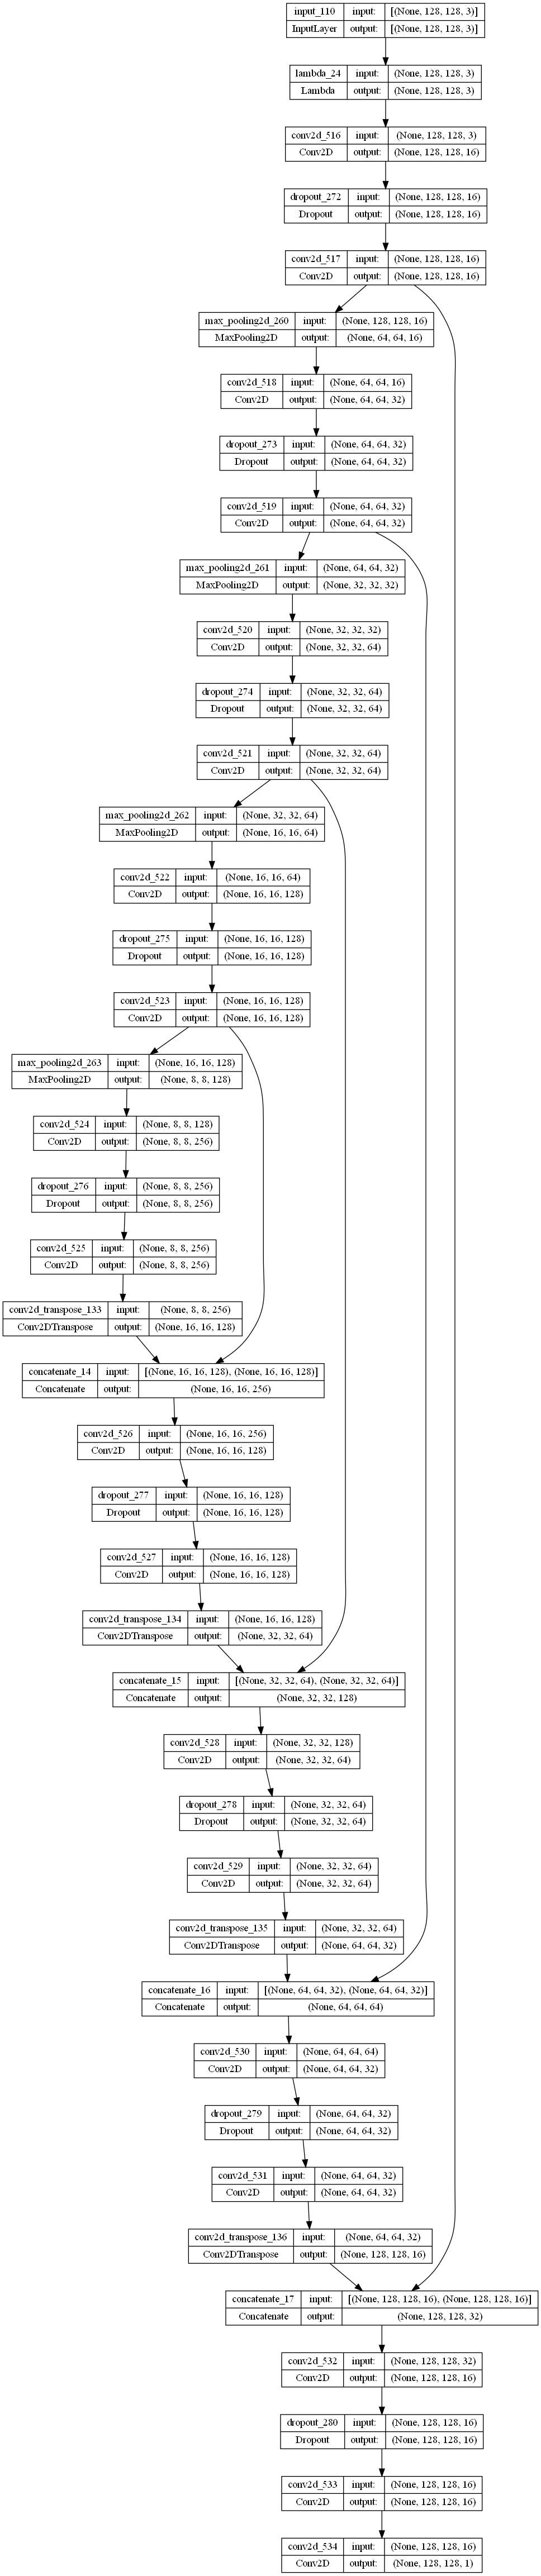

In [317]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='unet.png', show_shapes=True, show_layer_names=True)

# UNDERSTANDING MODELS

In [140]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [141]:
X = np.arange(0,1000)
Y = np.random.randint(0,255,len(X))

In [142]:
X.shape

(1000,)

In [143]:
def build_model(input_shape):
    x = Input(shape=input_shape)
    out = Linear(128, 1)(x)
    model = Model(inputs=[x], outputs=[out])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    model.summary()
    return model



linear = build_model(1)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 1)]               0         
                                                                 
 linear_18 (Linear)          (None, 128)               256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [144]:
linear.fit(X,Y)

32/32 [==============================] - 0s 2ms/step - loss: 21489.5605 - accuracy: 0.0030
